**SEGMENTATION MAP MODEL**

Generate segmentation map for every satellite view image from dataset  
(to be used as ground truth for transformer model)

In [14]:
%pip install torch torchvision matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [15]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [16]:
import torch


if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Playground

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

load image

Ground view images dimension: (1232, 224)
Satellite images dimension: (750, 750)


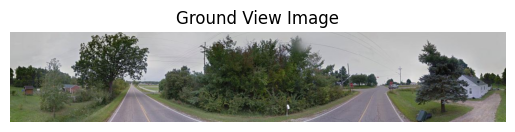

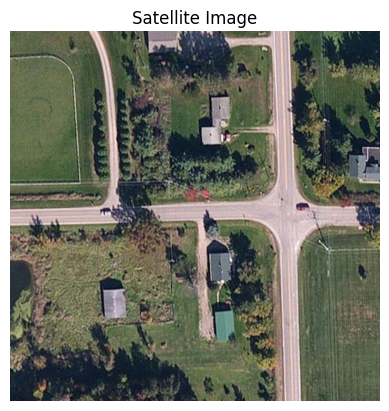

In [19]:
if is_colab():
    ground_view_image_path = '/content/drive/MyDrive/CV_dataset/CVPR_subset/streetview/streetview/panos/0027458.jpg'
    satellite_image_path = '/content/drive/MyDrive/CV_dataset/CVPR_subset/bingmap/bingmap/19/0027458.jpg'
else:
    ground_view_image_path = './CV_dataset/CVPR_subset/streetview/streetview/panos/0027458.jpg'
    satellite_image_path = './CV_dataset/CVPR_subset/bingmap/bingmap/19/0027458.jpg'

ground_img = Image.open(ground_view_image_path).convert('RGB')
aerial_img = Image.open(satellite_image_path).convert('RGB')
# already RGB

#print(f"Ground view image mode: {ground_img.mode}\nSatellite image mode: {aerial_img.mode}")
print(f"Ground view images dimension: {ground_img.size}\nSatellite images dimension: {aerial_img.size}")

plt.figure()
plt.title('Ground View Image')
plt.imshow(ground_img)
plt.axis('off')
plt.show()

plt.figure()
plt.title('Satellite Image')
plt.imshow(aerial_img)
plt.axis('off')
plt.show()

transforms

Transformed ground tensor shape: torch.Size([3, 224, 224])
Transformed aerial tensor shape: torch.Size([3, 224, 224])


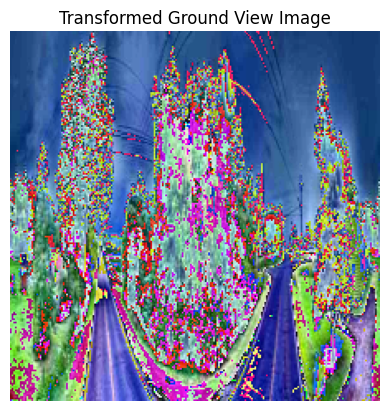

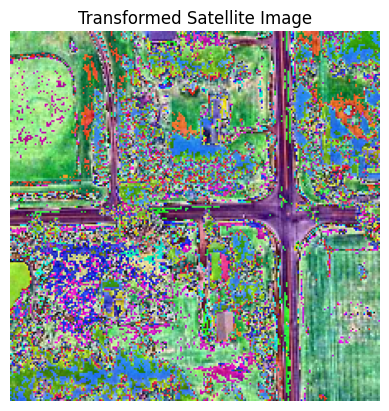

In [ ]:
ground_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # standard ImageNet normalization
])
aerial_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])     # standard ImageNet normalization
])
# Apply preprocessing
ground_tensor = ground_transform(ground_img)
aerial_tensor = aerial_transform(aerial_img)

# Add batch dimension
ground_input_batch = ground_tensor.unsqueeze(0)
aerial_input_batch = aerial_tensor.unsqueeze(0)
# Move to GPU
ground_input_batch = ground_input_batch.to(device)
aerial_input_batch = aerial_input_batch.to(device)


# VISUALIZATION
print(f"Transformed ground tensor shape: {ground_tensor.shape}")
print(f"Transformed aerial tensor shape: {aerial_tensor.shape}")

# Convert tensors back to PIL Images for visualization
ground_img_transformed = transforms.ToPILImage()(ground_tensor)
aerial_img_transformed = transforms.ToPILImage()(aerial_tensor)

plt.figure()
plt.title('Transformed Ground View Image')
plt.imshow(ground_img_transformed)
plt.axis('off')
plt.show()

plt.figure()
plt.title('Transformed Satellite Image')
plt.imshow(aerial_img_transformed)
plt.axis('off')
plt.show()

## DeepLabv3+
pre-trained on SpaceNet

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101

In [ ]:
# Load DeepLabv3+ with ResNet101 backbone
model_deeplabv3_plus = deeplabv3_resnet101(pretrained=False, num_classes=5)

# Load SpaceNet pretrained weights
!wget -O segmap_assets/deeplab_os16_epoch-10.pth https://github.com/avanetten/spacenet_off_nadir_models/releases/download/v1.0/deeplab_os16_epoch-10.pth


# Load weights
state_dict = torch.load('segmap_assets/deeplab_os16_epoch-10.pth', map_location=device)
model_deeplabv3_plus.load_state_dict(state_dict)
model_deeplabv3_plus = model_deeplab.to(device).eval()

/home/filippo/Scrivania/Computer Vision/CV_Project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/filippo/Scrivania/Computer Vision/CV_Project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


--2025-06-22 20:58:58--  https://github.com/avanetten/spacenet_off_nadir_models/releases/download/v1.0/deeplab_os16_epoch-10.pth
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-06-22 20:58:58 ERROR 404: Not Found.



EOFError: 

In [ ]:
with torch.no_grad():
    output = model_deeplabv3_plus(aerial_input_batch)['out']
    
# Get predictions
predictions_deeplab = output.argmax(1).squeeze().cpu().numpy()

# Define SpaceNet classes
CLASSES = [
    "Background", 
    "Roads", 
    "Buildings", 
    "Vegetation", 
    "Water"
]

# Visualize results
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(satellite_np)
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(predictions_deeplab, cmap='jet')
plt.title('DeepLabv3+ Segmentation')
plt.colorbar(ticks=range(len(CLASSES)), label='Classes')
plt.clim(0, len(CLASSES)-1)
plt.axis('off')
plt.tight_layout()
plt.show()

## U-Net

### approach with segmentation_models_pytorch (without solaris)

In [49]:
%pip install segmentation-models-pytorch opencv-python -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from segmentation_models_pytorch import Unet

In [57]:
# Load satellite image (256x256)
aerial_img_resized = aerial_img.resize((256, 256), Image.BILINEAR)
aerial_img_np = np.array(aerial_img_resized)

# Preprocessing function
def preprocess_image(img):
    # Normalize with ImageNet stats
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

# Preprocess the image
input_tensor = preprocess_image(aerial_img_np)

In [58]:
# Initialize model (matches SpaceNet4 winner architecture)
model = Unet(
    encoder_name='resnet34',
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation='sigmoid'
)

# Load your downloaded weights
weights_path = "./segmap_assets/selimsef_spacenet4_resnet34unet_solaris_weights.pth"
state_dict = torch.load(weights_path, map_location='cpu')

# Adjust for potential key naming differences
if all(k.startswith('module.') for k in state_dict):
    state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model.eval()  # Set to evaluation mode

RuntimeError: Error(s) in loading state_dict for Unet:
	Missing key(s) in state_dict: "encoder.conv1.weight", "encoder.bn1.weight", "encoder.bn1.bias", "encoder.bn1.running_mean", "encoder.bn1.running_var", "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.2.conv1.weight", "encoder.layer1.2.bn1.weight", "encoder.layer1.2.bn1.bias", "encoder.layer1.2.bn1.running_mean", "encoder.layer1.2.bn1.running_var", "encoder.layer1.2.conv2.weight", "encoder.layer1.2.bn2.weight", "encoder.layer1.2.bn2.bias", "encoder.layer1.2.bn2.running_mean", "encoder.layer1.2.bn2.running_var", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.2.conv1.weight", "encoder.layer2.2.bn1.weight", "encoder.layer2.2.bn1.bias", "encoder.layer2.2.bn1.running_mean", "encoder.layer2.2.bn1.running_var", "encoder.layer2.2.conv2.weight", "encoder.layer2.2.bn2.weight", "encoder.layer2.2.bn2.bias", "encoder.layer2.2.bn2.running_mean", "encoder.layer2.2.bn2.running_var", "encoder.layer2.3.conv1.weight", "encoder.layer2.3.bn1.weight", "encoder.layer2.3.bn1.bias", "encoder.layer2.3.bn1.running_mean", "encoder.layer2.3.bn1.running_var", "encoder.layer2.3.conv2.weight", "encoder.layer2.3.bn2.weight", "encoder.layer2.3.bn2.bias", "encoder.layer2.3.bn2.running_mean", "encoder.layer2.3.bn2.running_var", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.2.conv1.weight", "encoder.layer3.2.bn1.weight", "encoder.layer3.2.bn1.bias", "encoder.layer3.2.bn1.running_mean", "encoder.layer3.2.bn1.running_var", "encoder.layer3.2.conv2.weight", "encoder.layer3.2.bn2.weight", "encoder.layer3.2.bn2.bias", "encoder.layer3.2.bn2.running_mean", "encoder.layer3.2.bn2.running_var", "encoder.layer3.3.conv1.weight", "encoder.layer3.3.bn1.weight", "encoder.layer3.3.bn1.bias", "encoder.layer3.3.bn1.running_mean", "encoder.layer3.3.bn1.running_var", "encoder.layer3.3.conv2.weight", "encoder.layer3.3.bn2.weight", "encoder.layer3.3.bn2.bias", "encoder.layer3.3.bn2.running_mean", "encoder.layer3.3.bn2.running_var", "encoder.layer3.4.conv1.weight", "encoder.layer3.4.bn1.weight", "encoder.layer3.4.bn1.bias", "encoder.layer3.4.bn1.running_mean", "encoder.layer3.4.bn1.running_var", "encoder.layer3.4.conv2.weight", "encoder.layer3.4.bn2.weight", "encoder.layer3.4.bn2.bias", "encoder.layer3.4.bn2.running_mean", "encoder.layer3.4.bn2.running_var", "encoder.layer3.5.conv1.weight", "encoder.layer3.5.bn1.weight", "encoder.layer3.5.bn1.bias", "encoder.layer3.5.bn1.running_mean", "encoder.layer3.5.bn1.running_var", "encoder.layer3.5.conv2.weight", "encoder.layer3.5.bn2.weight", "encoder.layer3.5.bn2.bias", "encoder.layer3.5.bn2.running_mean", "encoder.layer3.5.bn2.running_var", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.2.conv1.weight", "encoder.layer4.2.bn1.weight", "encoder.layer4.2.bn1.bias", "encoder.layer4.2.bn1.running_mean", "encoder.layer4.2.bn1.running_var", "encoder.layer4.2.conv2.weight", "encoder.layer4.2.bn2.weight", "encoder.layer4.2.bn2.bias", "encoder.layer4.2.bn2.running_mean", "encoder.layer4.2.bn2.running_var", "decoder.blocks.0.conv1.0.weight", "decoder.blocks.0.conv1.1.weight", "decoder.blocks.0.conv1.1.bias", "decoder.blocks.0.conv1.1.running_mean", "decoder.blocks.0.conv1.1.running_var", "decoder.blocks.0.conv2.0.weight", "decoder.blocks.0.conv2.1.weight", "decoder.blocks.0.conv2.1.bias", "decoder.blocks.0.conv2.1.running_mean", "decoder.blocks.0.conv2.1.running_var", "decoder.blocks.1.conv1.0.weight", "decoder.blocks.1.conv1.1.weight", "decoder.blocks.1.conv1.1.bias", "decoder.blocks.1.conv1.1.running_mean", "decoder.blocks.1.conv1.1.running_var", "decoder.blocks.1.conv2.0.weight", "decoder.blocks.1.conv2.1.weight", "decoder.blocks.1.conv2.1.bias", "decoder.blocks.1.conv2.1.running_mean", "decoder.blocks.1.conv2.1.running_var", "decoder.blocks.2.conv1.0.weight", "decoder.blocks.2.conv1.1.weight", "decoder.blocks.2.conv1.1.bias", "decoder.blocks.2.conv1.1.running_mean", "decoder.blocks.2.conv1.1.running_var", "decoder.blocks.2.conv2.0.weight", "decoder.blocks.2.conv2.1.weight", "decoder.blocks.2.conv2.1.bias", "decoder.blocks.2.conv2.1.running_mean", "decoder.blocks.2.conv2.1.running_var", "decoder.blocks.3.conv1.0.weight", "decoder.blocks.3.conv1.1.weight", "decoder.blocks.3.conv1.1.bias", "decoder.blocks.3.conv1.1.running_mean", "decoder.blocks.3.conv1.1.running_var", "decoder.blocks.3.conv2.0.weight", "decoder.blocks.3.conv2.1.weight", "decoder.blocks.3.conv2.1.bias", "decoder.blocks.3.conv2.1.running_mean", "decoder.blocks.3.conv2.1.running_var", "decoder.blocks.4.conv1.0.weight", "decoder.blocks.4.conv1.1.weight", "decoder.blocks.4.conv1.1.bias", "decoder.blocks.4.conv1.1.running_mean", "decoder.blocks.4.conv1.1.running_var", "decoder.blocks.4.conv2.0.weight", "decoder.blocks.4.conv2.1.weight", "decoder.blocks.4.conv2.1.bias", "decoder.blocks.4.conv2.1.running_mean", "decoder.blocks.4.conv2.1.running_var", "segmentation_head.0.weight", "segmentation_head.0.bias". 
	Unexpected key(s) in state_dict: "bottlenecks.0.seq.0.weight", "bottlenecks.0.seq.0.bias", "bottlenecks.1.seq.0.weight", "bottlenecks.1.seq.0.bias", "bottlenecks.2.seq.0.weight", "bottlenecks.2.seq.0.bias", "bottlenecks.3.seq.0.weight", "bottlenecks.3.seq.0.bias", "decoder_stages.0.layer.1.weight", "decoder_stages.0.layer.1.bias", "decoder_stages.1.layer.1.weight", "decoder_stages.1.layer.1.bias", "decoder_stages.2.layer.1.weight", "decoder_stages.2.layer.1.bias", "decoder_stages.3.layer.1.weight", "decoder_stages.3.layer.1.bias", "last_upsample.layer.1.weight", "last_upsample.layer.1.bias", "final.0.weight", "final.0.bias", "encoder_stages.0.0.weight", "encoder_stages.0.1.weight", "encoder_stages.0.1.bias", "encoder_stages.0.1.running_mean", "encoder_stages.0.1.running_var", "encoder_stages.0.1.num_batches_tracked", "encoder_stages.1.1.0.conv1.weight", "encoder_stages.1.1.0.bn1.weight", "encoder_stages.1.1.0.bn1.bias", "encoder_stages.1.1.0.bn1.running_mean", "encoder_stages.1.1.0.bn1.running_var", "encoder_stages.1.1.0.bn1.num_batches_tracked", "encoder_stages.1.1.0.conv2.weight", "encoder_stages.1.1.0.bn2.weight", "encoder_stages.1.1.0.bn2.bias", "encoder_stages.1.1.0.bn2.running_mean", "encoder_stages.1.1.0.bn2.running_var", "encoder_stages.1.1.0.bn2.num_batches_tracked", "encoder_stages.1.1.1.conv1.weight", "encoder_stages.1.1.1.bn1.weight", "encoder_stages.1.1.1.bn1.bias", "encoder_stages.1.1.1.bn1.running_mean", "encoder_stages.1.1.1.bn1.running_var", "encoder_stages.1.1.1.bn1.num_batches_tracked", "encoder_stages.1.1.1.conv2.weight", "encoder_stages.1.1.1.bn2.weight", "encoder_stages.1.1.1.bn2.bias", "encoder_stages.1.1.1.bn2.running_mean", "encoder_stages.1.1.1.bn2.running_var", "encoder_stages.1.1.1.bn2.num_batches_tracked", "encoder_stages.1.1.2.conv1.weight", "encoder_stages.1.1.2.bn1.weight", "encoder_stages.1.1.2.bn1.bias", "encoder_stages.1.1.2.bn1.running_mean", "encoder_stages.1.1.2.bn1.running_var", "encoder_stages.1.1.2.bn1.num_batches_tracked", "encoder_stages.1.1.2.conv2.weight", "encoder_stages.1.1.2.bn2.weight", "encoder_stages.1.1.2.bn2.bias", "encoder_stages.1.1.2.bn2.running_mean", "encoder_stages.1.1.2.bn2.running_var", "encoder_stages.1.1.2.bn2.num_batches_tracked", "encoder_stages.2.0.conv1.weight", "encoder_stages.2.0.bn1.weight", "encoder_stages.2.0.bn1.bias", "encoder_stages.2.0.bn1.running_mean", "encoder_stages.2.0.bn1.running_var", "encoder_stages.2.0.bn1.num_batches_tracked", "encoder_stages.2.0.conv2.weight", "encoder_stages.2.0.bn2.weight", "encoder_stages.2.0.bn2.bias", "encoder_stages.2.0.bn2.running_mean", "encoder_stages.2.0.bn2.running_var", "encoder_stages.2.0.bn2.num_batches_tracked", "encoder_stages.2.0.downsample.0.weight", "encoder_stages.2.0.downsample.1.weight", "encoder_stages.2.0.downsample.1.bias", "encoder_stages.2.0.downsample.1.running_mean", "encoder_stages.2.0.downsample.1.running_var", "encoder_stages.2.0.downsample.1.num_batches_tracked", "encoder_stages.2.1.conv1.weight", "encoder_stages.2.1.bn1.weight", "encoder_stages.2.1.bn1.bias", "encoder_stages.2.1.bn1.running_mean", "encoder_stages.2.1.bn1.running_var", "encoder_stages.2.1.bn1.num_batches_tracked", "encoder_stages.2.1.conv2.weight", "encoder_stages.2.1.bn2.weight", "encoder_stages.2.1.bn2.bias", "encoder_stages.2.1.bn2.running_mean", "encoder_stages.2.1.bn2.running_var", "encoder_stages.2.1.bn2.num_batches_tracked", "encoder_stages.2.2.conv1.weight", "encoder_stages.2.2.bn1.weight", "encoder_stages.2.2.bn1.bias", "encoder_stages.2.2.bn1.running_mean", "encoder_stages.2.2.bn1.running_var", "encoder_stages.2.2.bn1.num_batches_tracked", "encoder_stages.2.2.conv2.weight", "encoder_stages.2.2.bn2.weight", "encoder_stages.2.2.bn2.bias", "encoder_stages.2.2.bn2.running_mean", "encoder_stages.2.2.bn2.running_var", "encoder_stages.2.2.bn2.num_batches_tracked", "encoder_stages.2.3.conv1.weight", "encoder_stages.2.3.bn1.weight", "encoder_stages.2.3.bn1.bias", "encoder_stages.2.3.bn1.running_mean", "encoder_stages.2.3.bn1.running_var", "encoder_stages.2.3.bn1.num_batches_tracked", "encoder_stages.2.3.conv2.weight", "encoder_stages.2.3.bn2.weight", "encoder_stages.2.3.bn2.bias", "encoder_stages.2.3.bn2.running_mean", "encoder_stages.2.3.bn2.running_var", "encoder_stages.2.3.bn2.num_batches_tracked", "encoder_stages.3.0.conv1.weight", "encoder_stages.3.0.bn1.weight", "encoder_stages.3.0.bn1.bias", "encoder_stages.3.0.bn1.running_mean", "encoder_stages.3.0.bn1.running_var", "encoder_stages.3.0.bn1.num_batches_tracked", "encoder_stages.3.0.conv2.weight", "encoder_stages.3.0.bn2.weight", "encoder_stages.3.0.bn2.bias", "encoder_stages.3.0.bn2.running_mean", "encoder_stages.3.0.bn2.running_var", "encoder_stages.3.0.bn2.num_batches_tracked", "encoder_stages.3.0.downsample.0.weight", "encoder_stages.3.0.downsample.1.weight", "encoder_stages.3.0.downsample.1.bias", "encoder_stages.3.0.downsample.1.running_mean", "encoder_stages.3.0.downsample.1.running_var", "encoder_stages.3.0.downsample.1.num_batches_tracked", "encoder_stages.3.1.conv1.weight", "encoder_stages.3.1.bn1.weight", "encoder_stages.3.1.bn1.bias", "encoder_stages.3.1.bn1.running_mean", "encoder_stages.3.1.bn1.running_var", "encoder_stages.3.1.bn1.num_batches_tracked", "encoder_stages.3.1.conv2.weight", "encoder_stages.3.1.bn2.weight", "encoder_stages.3.1.bn2.bias", "encoder_stages.3.1.bn2.running_mean", "encoder_stages.3.1.bn2.running_var", "encoder_stages.3.1.bn2.num_batches_tracked", "encoder_stages.3.2.conv1.weight", "encoder_stages.3.2.bn1.weight", "encoder_stages.3.2.bn1.bias", "encoder_stages.3.2.bn1.running_mean", "encoder_stages.3.2.bn1.running_var", "encoder_stages.3.2.bn1.num_batches_tracked", "encoder_stages.3.2.conv2.weight", "encoder_stages.3.2.bn2.weight", "encoder_stages.3.2.bn2.bias", "encoder_stages.3.2.bn2.running_mean", "encoder_stages.3.2.bn2.running_var", "encoder_stages.3.2.bn2.num_batches_tracked", "encoder_stages.3.3.conv1.weight", "encoder_stages.3.3.bn1.weight", "encoder_stages.3.3.bn1.bias", "encoder_stages.3.3.bn1.running_mean", "encoder_stages.3.3.bn1.running_var", "encoder_stages.3.3.bn1.num_batches_tracked", "encoder_stages.3.3.conv2.weight", "encoder_stages.3.3.bn2.weight", "encoder_stages.3.3.bn2.bias", "encoder_stages.3.3.bn2.running_mean", "encoder_stages.3.3.bn2.running_var", "encoder_stages.3.3.bn2.num_batches_tracked", "encoder_stages.3.4.conv1.weight", "encoder_stages.3.4.bn1.weight", "encoder_stages.3.4.bn1.bias", "encoder_stages.3.4.bn1.running_mean", "encoder_stages.3.4.bn1.running_var", "encoder_stages.3.4.bn1.num_batches_tracked", "encoder_stages.3.4.conv2.weight", "encoder_stages.3.4.bn2.weight", "encoder_stages.3.4.bn2.bias", "encoder_stages.3.4.bn2.running_mean", "encoder_stages.3.4.bn2.running_var", "encoder_stages.3.4.bn2.num_batches_tracked", "encoder_stages.3.5.conv1.weight", "encoder_stages.3.5.bn1.weight", "encoder_stages.3.5.bn1.bias", "encoder_stages.3.5.bn1.running_mean", "encoder_stages.3.5.bn1.running_var", "encoder_stages.3.5.bn1.num_batches_tracked", "encoder_stages.3.5.conv2.weight", "encoder_stages.3.5.bn2.weight", "encoder_stages.3.5.bn2.bias", "encoder_stages.3.5.bn2.running_mean", "encoder_stages.3.5.bn2.running_var", "encoder_stages.3.5.bn2.num_batches_tracked", "encoder_stages.4.0.conv1.weight", "encoder_stages.4.0.bn1.weight", "encoder_stages.4.0.bn1.bias", "encoder_stages.4.0.bn1.running_mean", "encoder_stages.4.0.bn1.running_var", "encoder_stages.4.0.bn1.num_batches_tracked", "encoder_stages.4.0.conv2.weight", "encoder_stages.4.0.bn2.weight", "encoder_stages.4.0.bn2.bias", "encoder_stages.4.0.bn2.running_mean", "encoder_stages.4.0.bn2.running_var", "encoder_stages.4.0.bn2.num_batches_tracked", "encoder_stages.4.0.downsample.0.weight", "encoder_stages.4.0.downsample.1.weight", "encoder_stages.4.0.downsample.1.bias", "encoder_stages.4.0.downsample.1.running_mean", "encoder_stages.4.0.downsample.1.running_var", "encoder_stages.4.0.downsample.1.num_batches_tracked", "encoder_stages.4.1.conv1.weight", "encoder_stages.4.1.bn1.weight", "encoder_stages.4.1.bn1.bias", "encoder_stages.4.1.bn1.running_mean", "encoder_stages.4.1.bn1.running_var", "encoder_stages.4.1.bn1.num_batches_tracked", "encoder_stages.4.1.conv2.weight", "encoder_stages.4.1.bn2.weight", "encoder_stages.4.1.bn2.bias", "encoder_stages.4.1.bn2.running_mean", "encoder_stages.4.1.bn2.running_var", "encoder_stages.4.1.bn2.num_batches_tracked", "encoder_stages.4.2.conv1.weight", "encoder_stages.4.2.bn1.weight", "encoder_stages.4.2.bn1.bias", "encoder_stages.4.2.bn1.running_mean", "encoder_stages.4.2.bn1.running_var", "encoder_stages.4.2.bn1.num_batches_tracked", "encoder_stages.4.2.conv2.weight", "encoder_stages.4.2.bn2.weight", "encoder_stages.4.2.bn2.bias", "encoder_stages.4.2.bn2.running_mean", "encoder_stages.4.2.bn2.running_var", "encoder_stages.4.2.bn2.num_batches_tracked". 

### reconstruct exactly the model (without solaris)

In [20]:
%pip install segmentation-models-pytorch opencv-python -q

Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch.nn as nn
import torch.nn.functional as F
import cv2

model

In [22]:
class ResNet34Encoder(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self._out_channels = [64, 64, 128, 256, 512]
        self.encoder_stages = nn.ModuleList()
        
        # Initial convolution
        self.encoder_stages.append(nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ))

        # Residual blocks
        self._make_layer(64, 64, 3, stride=1, index=1)   # Layer1
        self._make_layer(64, 128, 4, stride=2, index=2)  # Layer2
        self._make_layer(128, 256, 6, stride=2, index=3) # Layer3
        self._make_layer(256, 512, 3, stride=2, index=4) # Layer4

    def _make_layer(self, in_channels, out_channels, blocks, stride, index):
        layers = []
        # Downsample layer
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        # First block
        layers.append(BasicBlock(in_channels, out_channels, stride, downsample))
        
        # Additional blocks
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        
        stage = nn.Sequential(*layers)
        self.encoder_stages.append(stage)

    def forward(self, x):
        features = []
        for stage in self.encoder_stages:
            x = stage(x)
            features.append(x)
        return features

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class UNet(nn.Module):
    def __init__(self, num_classes=3, decoder_channels=256):
        super().__init__()
        self.encoder = ResNet34Encoder(in_channels=4)
        encoder_channels = self.encoder._out_channels
        
        # Bottleneck layers
        self.bottlenecks = nn.ModuleList([
            self._make_bottleneck(ch, decoder_channels) for ch in reversed(encoder_channels)
        ])
        
        # Decoder stages
        self.decoder_stages = nn.ModuleList()
        for i in range(len(encoder_channels) - 1):
            self.decoder_stages.append(nn.Sequential(
                nn.Conv2d(decoder_channels*2, decoder_channels, kernel_size=3, padding=1, bias=False),
                #nn.Conv2d(decoder_channels, decoder_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(decoder_channels),
                nn.ReLU(inplace=True)
            ))
        
        # Final layers
        self.last_upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(decoder_channels, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_bottleneck(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        encoder_features = self.encoder(x)
        
        # Process through bottlenecks
        features = []
        for i, feat in enumerate(reversed(encoder_features)):
            features.append(self.bottlenecks[i](feat))
        
        # Decoder with skip connections
        x = features[0]
        for i in range(len(self.decoder_stages)):
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)

            # Get skip connection and resize if needed
            skip = features[i+1]
            if skip.shape[-2:] != x.shape[-2:]:
                skip = F.interpolate(skip, size=x.shape[-2:], mode='bilinear', align_corners=True)

            x = torch.cat([x, skip], dim=1)
            #x = torch.cat([x, features[i+1]], dim=1)
            
            x = self.decoder_stages[i](x)
        
        # Final processing
        x = self.last_upsample(x)
        return self.final(x)

# Initialize and load weights
model = UNet(num_classes=3)

# Load state dict with strict=False to ignore missing keys
state_dict = torch.load('segmap_assets/selimsef_spacenet4_resnet34unet_solaris_weights.pth', map_location=device)
model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.eval()

UNet(
  (encoder): ResNet34Encoder(
    (encoder_stages): ModuleList(
      (0): Sequential(
        (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

Output min: -2.396998167037964 max: 1.5595765113830566 mean: -0.41223692893981934
Output shape: torch.Size([1, 3, 256, 256])


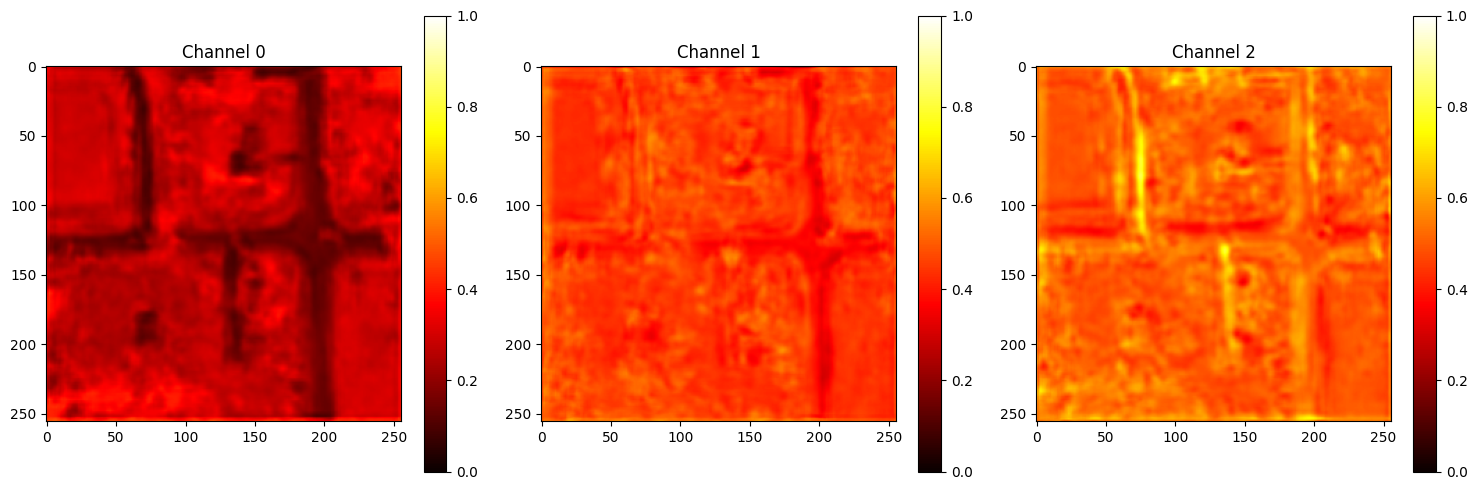

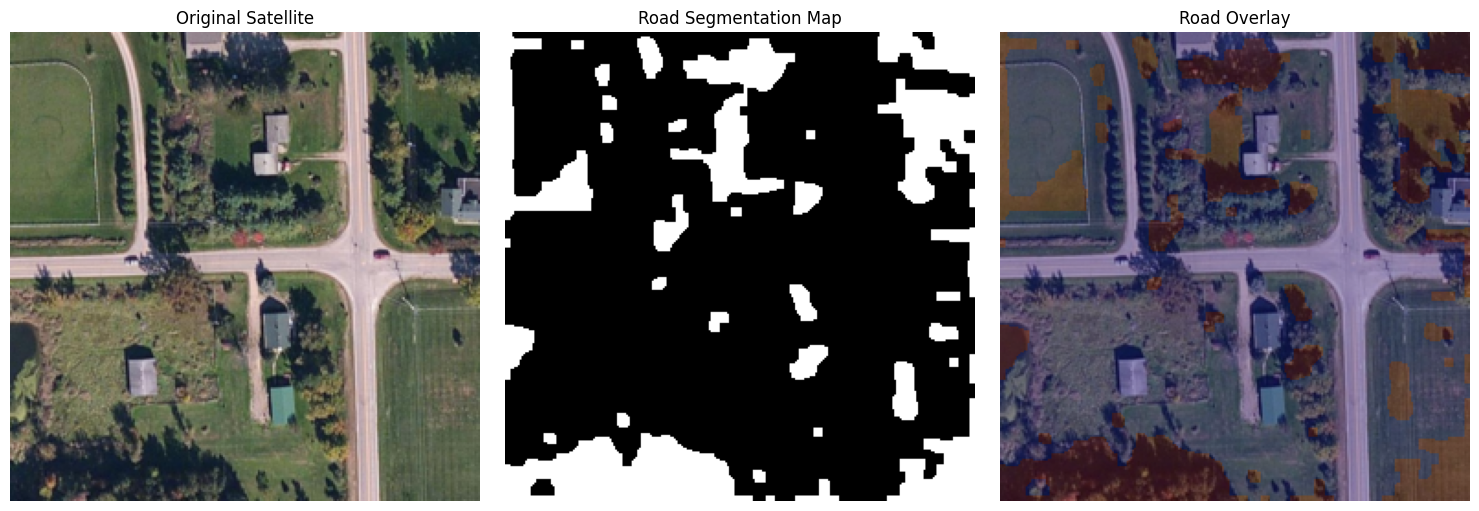

In [27]:
# Preprocessing function
def preprocess_unet(image):
    # # reshape satellite image to 256x256
    # img_resized = image.resize((256, 256), Image.BILINEAR)
    # img_np = np.array(img_resized)
    img_np = np.array(image)

    # Add Near-Infrared channel if missing (use red channel as placeholder)
    if img_np.shape[2] == 3:
        nir = img_np[..., 0].copy()  # Use red channel as NIR proxy
        img_np = np.dstack([img_np, nir])
        #img_np = np.concatenate([img_np, np.zeros(img_np.shape[:2] + (1,), dtype=img_np.dtype)], axis=2)
    
    # Normalize with ImageNet stats
    transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        transforms.Normalize(mean=[0.006479, 0.009328, 0.01123, 0.02082], std=[0.004986, 0.004964, 0.004950, 0.004878])
    ])
    return transform(img_np).unsqueeze(0)  # Add batch dimension
    

# def preprocess_unet(image):
#     arr = np.array(image)
    
#     if arr.ndim == 2:  # Grayscale
#         arr = np.stack([arr]*3, axis=-1)
    
#     # Add Near-Infrared channel if missing (use red channel as placeholder)
#     if arr.shape[2] == 3:
#         # Use red channel as NIR placeholder (better than zeros)
#         nir = arr[..., 0].copy()  # Use red channel as NIR proxy
#         arr = np.dstack([arr, nir])
#         #arr = np.concatenate([arr, np.zeros(arr.shape[:2] + (1,), dtype=arr.dtype)], axis=2)
#     image = Image.fromarray(arr)
    
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((384, 384)),
#         transforms.Normalize(mean=[0.006479, 0.009328, 0.01123, 0.02082], std=[0.004986, 0.004964, 0.004950, 0.004878])
#     ])
#     return transform(Image.fromarray(arr)).unsqueeze(0)
#     #return transform(image).unsqueeze(0)



# Postprocessing function
def postprocess_mask(output, original_size):
    # Apply sigmoid activation to get probabilities
    prob_mask = torch.sigmoid(output)
    
    # Select road channel (index 1) - adjust if needed for your model
    road_mask = prob_mask[0, 1].cpu().numpy()  # Shape: (384, 384)
    
    # Threshold and convert to uint8
    binary_mask = (road_mask > 0.5).astype(np.uint8) * 255
    
    # Resize to original dimensions (width, height)
    resized_mask = cv2.resize(binary_mask, original_size, interpolation=cv2.INTER_NEAREST)
    
    # Clean small artifacts
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(resized_mask, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)
    
    return cleaned_mask


########################################################################## DEBUG
# Visualize all channels
def visualize_channels(prob_mask, original_size):
    # Resize each channel to original size
    resized_channels = []
    for i in range(prob_mask.shape[0]):
        channel = cv2.resize(prob_mask[i], original_size, interpolation=cv2.INTER_NEAREST)
        resized_channels.append(channel)
    
    # Plot all channels
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(resized_channels[i], cmap='hot', vmin=0, vmax=1)
        plt.title(f'Channel {i}')
        plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    return resized_channels
########################################################################## DEBUG


# Process satellite image
def generate_segmap(img):
    original_size = img.size    # (width, height)
    
    # Preprocess
    input_tensor = preprocess_unet(img).to(device)
    
    # Predict
    with torch.no_grad():
        #output = model_unet(input_tensor)
        output = model(input_tensor)
        
        ########################################## DEBUG
        print("Output min:", output.min().item(), 
              "max:", output.max().item(),
              "mean:", output.mean().item())
        print("Output shape:", output.shape)
        ########################################## DEBUG
    
    # Postprocess
    # road_mask = postprocess_mask(output, original_size)
    # return np.array(img), road_mask

    ########################################## DEBUG
    # Get probability masks for all channels
    prob_mask = torch.sigmoid(output)[0].cpu().numpy()

    # DEBUG: Visualize all channels
    channel_masks = visualize_channels(prob_mask, original_size)
    
    # Assuming channel 0 is background, channel 1 is roads, channel 2 is intersections
    road_mask = channel_masks[0]  # Try different channels here
    
    # Threshold and convert to uint8
    binary_mask = (road_mask > 0.3).astype(np.uint8) * 255
    
    # Clean small artifacts
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, kernel)

    
    return np.array(img), cleaned_mask
    ########################################## DEBUG





# Run segmentation
img_resized = aerial_img.resize((256, 256), Image.BILINEAR)
sat_img, mask = generate_segmap(img_resized)
#sat_img, mask = generate_segmap(aerial_img)

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(sat_img)
plt.title('Original Satellite')
plt.axis('off')

plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('Road Segmentation Map')
plt.axis('off')

plt.subplot(133)
plt.imshow(sat_img)
plt.imshow(mask, alpha=0.3, cmap='jet')
plt.title('Road Overlay')
plt.axis('off')
plt.tight_layout()
plt.show()

### with solaris

In [20]:
#%pip install solaris -q

import solaris as sol
#from solaris.nets.datagen import make_data_generator
from solaris.nets import TorchUNet

ImportError: cannot import name 'TorchUNet' from 'solaris.nets' (/home/filippo/miniconda3/envs/solaris/lib/python3.7/site-packages/solaris/nets/__init__.py)

In [22]:
aerial_img_np = np.array(aerial_img)

model_unet = sol.nets.load_model(
    model_arch='unet',
    encoder_name='resnet34',
    encoder_weights='imagenet',
    classes=3,  # or 7, depending on your weights
    activation=None,
    weights_path='segmap_assets/selimsef_spacenet4_resnet34unet_solaris_weights.pth',
    device=device
)
model_unet.eval()

# # Initialize Solaris U-Net model
# model_unet = sol.nets.train.TrainSegModel(
#     architecture='unet',  # U-Net architecture
#     backbone='resnet34',   # ResNet34 backbone
#     pretrained=True,       # Use ImageNet pretrained weights
#     num_classes=7,         # Binary segmentation (roads/buildings)
#     learning_rate=0.001    # Default LR (not used for inference)
# )
# # Load SpaceNet4 weights
# model_unet.load_state_dict(torch.load('segmap_assets/selimsef_spacenet4_resnet34unet_solaris_weights.pth', map_location=device))
# model_unet.eval()  # Set to evaluation mode



# Preprocess image
preprocessor = sol.utils.data.SegmentationTiler(
    tile_size=(512, 512),
    overlap=0.1,           # 10% overlap to avoid edge artifacts
    image_type='rgb'
)
tiles, tile_metadata = preprocessor.tile(aerial_img_np)



# Predict segmentation masks
segmentation = np.zeros(aerial_img_np.shape[:2], dtype=np.uint8)
for i, tile in enumerate(tiles):
    tile_tensor = torch.tensor(tile).permute(2, 0, 1).float().unsqueeze(0) / 255.0
    with torch.no_grad():
        pred = torch.sigmoid(model_unet(tile_tensor)).squeeze().numpy()
    tile_mask = (pred > 0.5).astype(np.uint8) * 255
    segmentation = preprocessor.untile(
        tile_mask, 
        i, 
        tile_metadata, 
        output_shape=segmentation.shape
    )

# Post-process to remove small artifacts
segmentation_cleaned = sol.utils.misc.clean_segmentation(
    segmentation,
    min_area=100,          # Remove objects smaller than 100px
    fill_holes=True
)

# Visualize results
plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(aerial_img_np)
plt.title('Original Satellite Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(segmentation, cmap='gray')
plt.title('U-Net Raw Segmentation')
plt.axis('off')

plt.subplot(133)
plt.imshow(segmentation_cleaned, cmap='gray')
plt.title('Cleaned Segmentation')
plt.axis('off')
plt.tight_layout()
plt.show()

AttributeError: module 'solaris.nets' has no attribute 'load_model'

# Implement for all dataset